# Book Genre Prediction

## 1 ) Importing Necessary Packages

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import Counter
from itertools import chain

# API Requests
import os
import requests

# language detection:
! pip install langdetect
from langdetect import detect

# random generator:
import random

# Text Cleaning / NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords=set(nltk.corpus.stopwords.words('english'))
import re
import string
from nltk.stem import PorterStemmer

# Vectorization / Label encoding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical, np_utils


# train test split
from sklearn.model_selection import train_test_split

# Baseline models:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid Search
from sklearn.model_selection import GridSearchCV

#evaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#keras
import keras
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

# Set Google Drive Directory:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/data/'
project_folder = "/content/gdrive/My Drive/Genre Detection"

## 2 ) Loading the Data

In [0]:
#import new version with 40 Genres:
books = pd.read_csv(project_folder + "/book_data.csv", error_bad_lines=False)

## 3 )  Getting a Basic Idea & Data Preprocessing

In [0]:
#check the columns:
col = books.columns
col

Index(['title', 'authors', 'isbn', 'description', 'Genre'], dtype='object')

In [0]:
# check for missing values:
for c in col:
  na_rows = np.where(books[c].isna())[0]
  print("found {} missing values in {}". format(len(na_rows),c))

found 0 missing values in title
found 2364 missing values in authors
found 0 missing values in isbn
found 0 missing values in description
found 0 missing values in Genre


Some books in the set don't have an author, so we try to scrape these from the Google Books API:

In [0]:
class gbooks():
  googleapikey="XXXXXX_PUT_YOUR_API_KEY_XXXXXXX"
  
  def search(self, value):
      parms = {"q":value, 'key':self.googleapikey}
      r = requests.get(url=" https://www.googleapis.com/books/v1/volumes?q=isbn:" + str(value) + "&key="+ self.googleapikey)
      rj = r.json()
      #print(rj) #print this to see if dayly limit has been exceeded
      if rj["totalItems"] != 0:
        for i in rj["items"]:
            try:
                #print (repr(i["volumeInfo"]["authors"]))
                return repr(i["volumeInfo"]["authors"])
                #indx = np.where(books["isbn13"] == value)[0]                
                #books["description"][indx] = repr(i["volumeInfo"]["description"])
            except:
                pass
      #print("ISBN {} not found".format(value))

In [0]:
# Iterate over ISBNs and request Google Books API for author information
indx = np.where(books["authors"].isna())[0]
for i in indx:
  bk = gbooks()
  books["authors"][i] = bk.search(books["isbn"][i])

In [0]:
# check again for missing values:
na_rows = np.where(books["authors"].isna())[0]
print("Still found {} missing values in authors". format(len(na_rows)))

#delete book where we couldn't scrape the author:
books_selected = books.drop(na_rows, axis=0)
print("Drop it like it's hot....")

print("Now the data set has {} instances". format(len(books_selected)))

Still found 531 missing values in authors
Drop it like it's hot....
Now the data set has 91363 instances


In [0]:
#Sneek peak into the descriptions:
for x in range(3):
  r = random.randint(1,len(books_selected)) 
  print("Random description: {}".format(books_selected["description"][r]))

Random description: Cat Wilcox has left chilly Boston for sunny Mexico and a summer of girl bonding with her best friend, Sabrina. But Sabrina has a surprise. She is accompanied by her boyfriend—a boyfriend Cat didn’t even know existed. So rather than Sabrina and Cat spending their study-abroad semester working together at the orphan school building site, Cat expects she’ll be hammering nails all by her lonesome. Then she meets Aidan. He’s cute, he’s smart, and he’s paying her a lot of attention. Cat can’t tell if he’s flirting or friendly, but she’s not sure it matters. Isn’t it easier to be just friends? But this is enchanted Mexico and, between hiking in the rain forest, diving off waterfalls, and finishing the orphan center, it’s going to take a little bit of salsa spirit, and a lot of heart, for Cat to make it through the summer unchanged.
Random description: A brilliant weave of personal involvement, vivid biography and political insight, Koba the Dread is the successor to Martin

In [0]:
#Finding Number of rows and columns
print("Dataset contains {} rows and {} columns".format(books_selected.shape[0], books_selected.shape[1]))

books[11090:11100]

Dataset contains 91363 rows and 5 columns


,title,authors,isbn,description,Genre
11090,Snowmobile,Jules Older,9781580893343,"In 1922, when Joseph-Armand Bombardier was fif...",Children’s Books
11091,Daring In a Blue Dress,Katie Macalister,9781101990667,Chivalry is far from dead in the third novel i...,Fiction
11092,The Mindful Path to Addiction Recovery,Lawrence Peltz,9781590309186,"Mindfulness, the quality of attention that com...",Self-Improvement
11093,Sailor Moon 4,Naoko Takeuchi,9781612620008,A new group calling themselves Black Moon is a...,Fiction
11094,Dark Places,Gillian Flynn,9781101902882,From the #1 New York Times bestselling author ...,Fiction
11095,The Darkest Evening of the Year,Dean Koontz,9780345533289,NEW YORK TIMES BESTSELLER Who will be with y...,Fiction
11096,Judge Dredd: Mega-City Zero Volume 3,"Ulises Farinas, Erick Freitas",9781631408380,Dredd finds himself the only judge in a Mega-C...,Fiction
11097,Vampire Hunter D Volume 13: Twin-Shadowed Knig...,Hideyuki Kikuchi,9781593079307,When Vampire Hunter D entered the town of Sedo...,Fiction
11098,"So Long, See You Tomorrow",William Maxwell,9780679767206,"In this magically evocative novel, William Max...",Fiction
11099,John Dos Passos: U.S.A. (LOA #85),John Dos Passos,9781883011147,Unique among American books for its epic scope...,Fiction


## 4 ) Exploratory Data Analysis & Data Preprocessing

### Which are the books with most occurances in the list? 

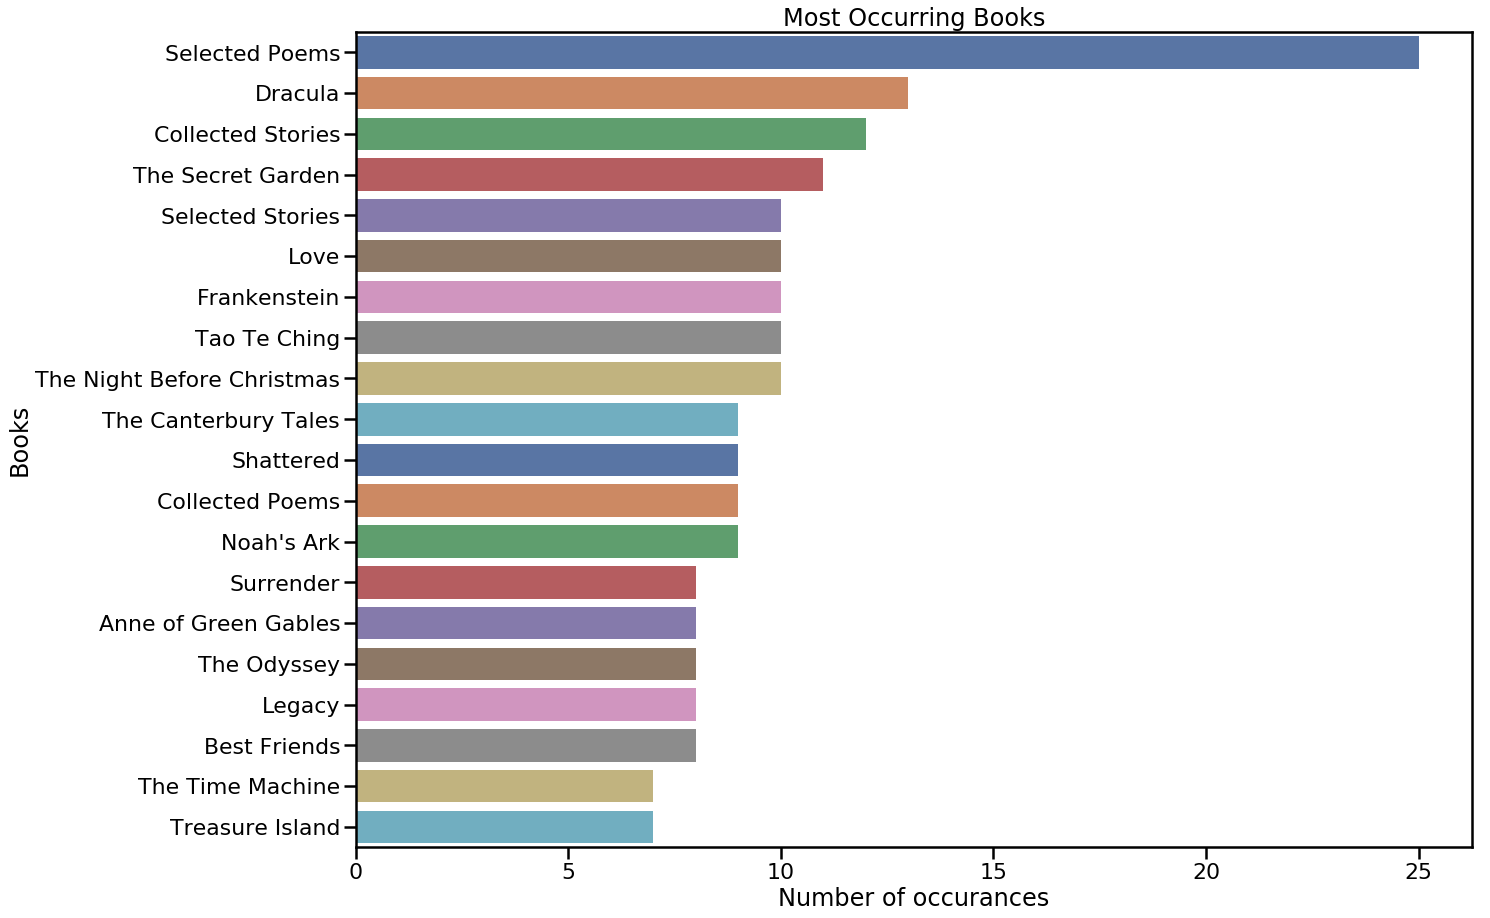

In [0]:
#Taking the first 20:
sns.set_context('poster')
plt.figure(figsize=(20,15))
first20books = books_selected['title'].value_counts()[:20]
sns.barplot(x = first20books, y = first20books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

Some book titles have more than one occurence. Apparently 25 authors came up with the creative idea to call their poem collection "Selected Poems". Very unique. They weren't the only ones though: Also "Collected Stories", "Selected Stories" and "The Complete Poems" are very popular book titles.

On the other hand we can see that some steadfast classics like "Dracula" by Bram Stoker and "Frankenstein" by Mary Shelley appear with various with various publication editions in the dataset. 

To be able to differentiate the books by Name, we rename them to "< book title> by < author>" and remove duplicates.

#### Rename and Delete Duplicates

In [0]:
# Delete duplicates
before = len(books_selected)

# Filter out book that have more than one occurence:
books_with_more_occurences = books_selected['title'].value_counts()
books_with_more_occurences = books_with_more_occurences[books_with_more_occurences > 1]

# for each duplicate booktitle, get the indexes of all occurences in books_selected:
for occurence in books_with_more_occurences.index:
  ind = np.where(books_selected["title"] == occurence)[0] 
  
  # Rename title to "<book title> by <author>"
  for i in ind:
    books_selected.iloc[i]["title"] = str(books_selected.iloc[i]["title"] + " by " + books_selected.iloc[i]["authors"])
    
# sorting by first name 
books_selected.sort_values("title", ascending = False, inplace = True)
  
# dropping duplicte values and only leave first occurence (if title and author were the same, they'd be dropped)
books_selected.drop_duplicates(subset ="title", 
                     keep='first', inplace = True) 

after = len(books_selected)
print("{} books were duplicates and were therefore removed. {} Books are left.".format(before-after, after))

5020 books were duplicates and were therefore removed. 86343 Books are left.


### Whats the summary length distribution?

The minimum length is 1 characters
The maximum length is 14977 characters


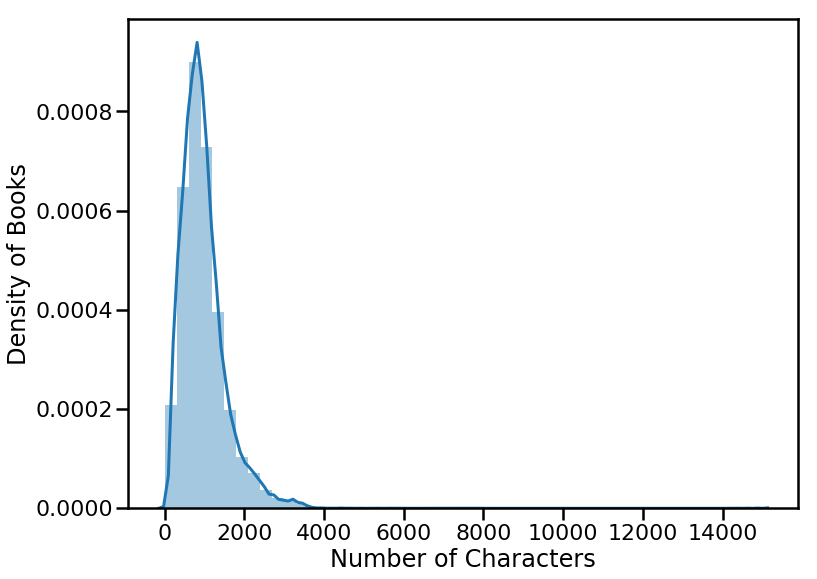

In [0]:
x = np.array([len(i) for i in books_selected["description"]])
#x.index = np.arange(len(books_selected["description"]))
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.distplot(x)

plt.figure(figsize=(12,9))
ax = sns.distplot(x)
ax.set_xlabel("Number of Characters")
ax.set_ylabel("Density of Books")


print("The minimum length is {} characters".format(x.min()))
print("The maximum length is {} characters".format(x.max()))

#### Delete books with descr < 130 characters

In [0]:
before = len(books_selected)

while (len(books_selected.iloc[np.argmin(x)]["description"]) < 150):
  index_min = np.argmin(x)
  books_selected = books_selected.drop(books_selected.index[index_min])  
  x = np.array([len(i) for i in books_selected["description"]])

after = len(books_selected)
print("{} book descriptions had less than 130 characters and were therefore removed. {} Books are left.".format(before-after, after))

751 book descriptions had less than 130 characters and were therefore removed. 85592 Books are left.


### How many categories are there and how are they distributed?

There are 48 different categories in the book data
The top 20 are:


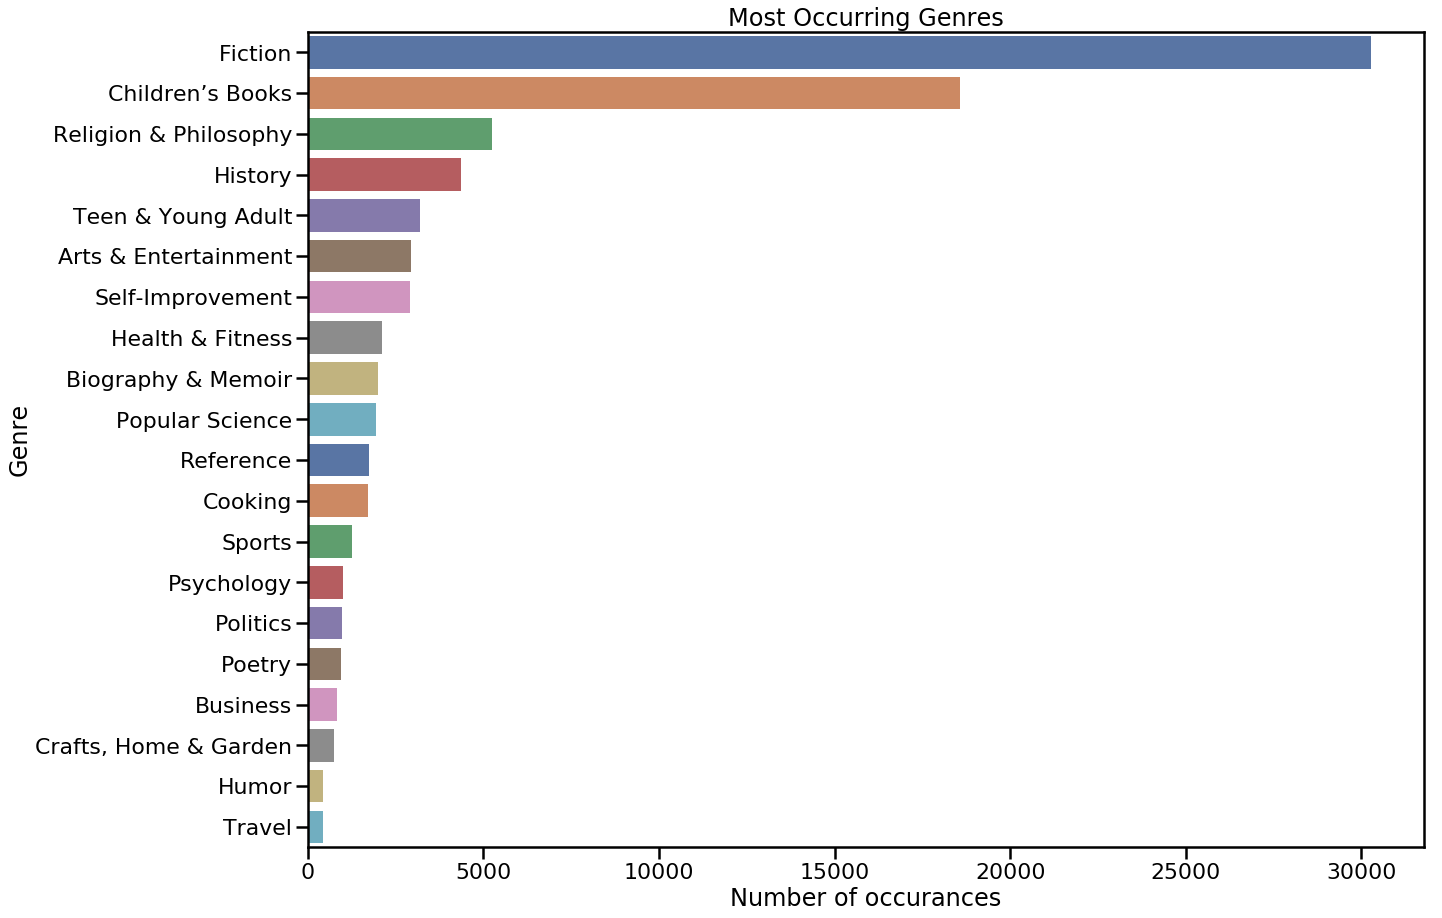

In [0]:
books_selected["Genre"] = [str(x) for x in books_selected["Genre"]]

print("There are {} different categories in the book data".format(len(np.unique(books_selected["Genre"]))))
print("The top 20 are:")

sns.set_context('poster')
plt.figure(figsize=(20,15))
first20categories = books_selected['Genre'].value_counts()[:20]
sns.barplot(x = first20categories, y = first20categories.index, palette='deep')
plt.title("Most Occurring Genres")
plt.xlabel("Number of occurances")
plt.ylabel("Genre")
plt.show()
    

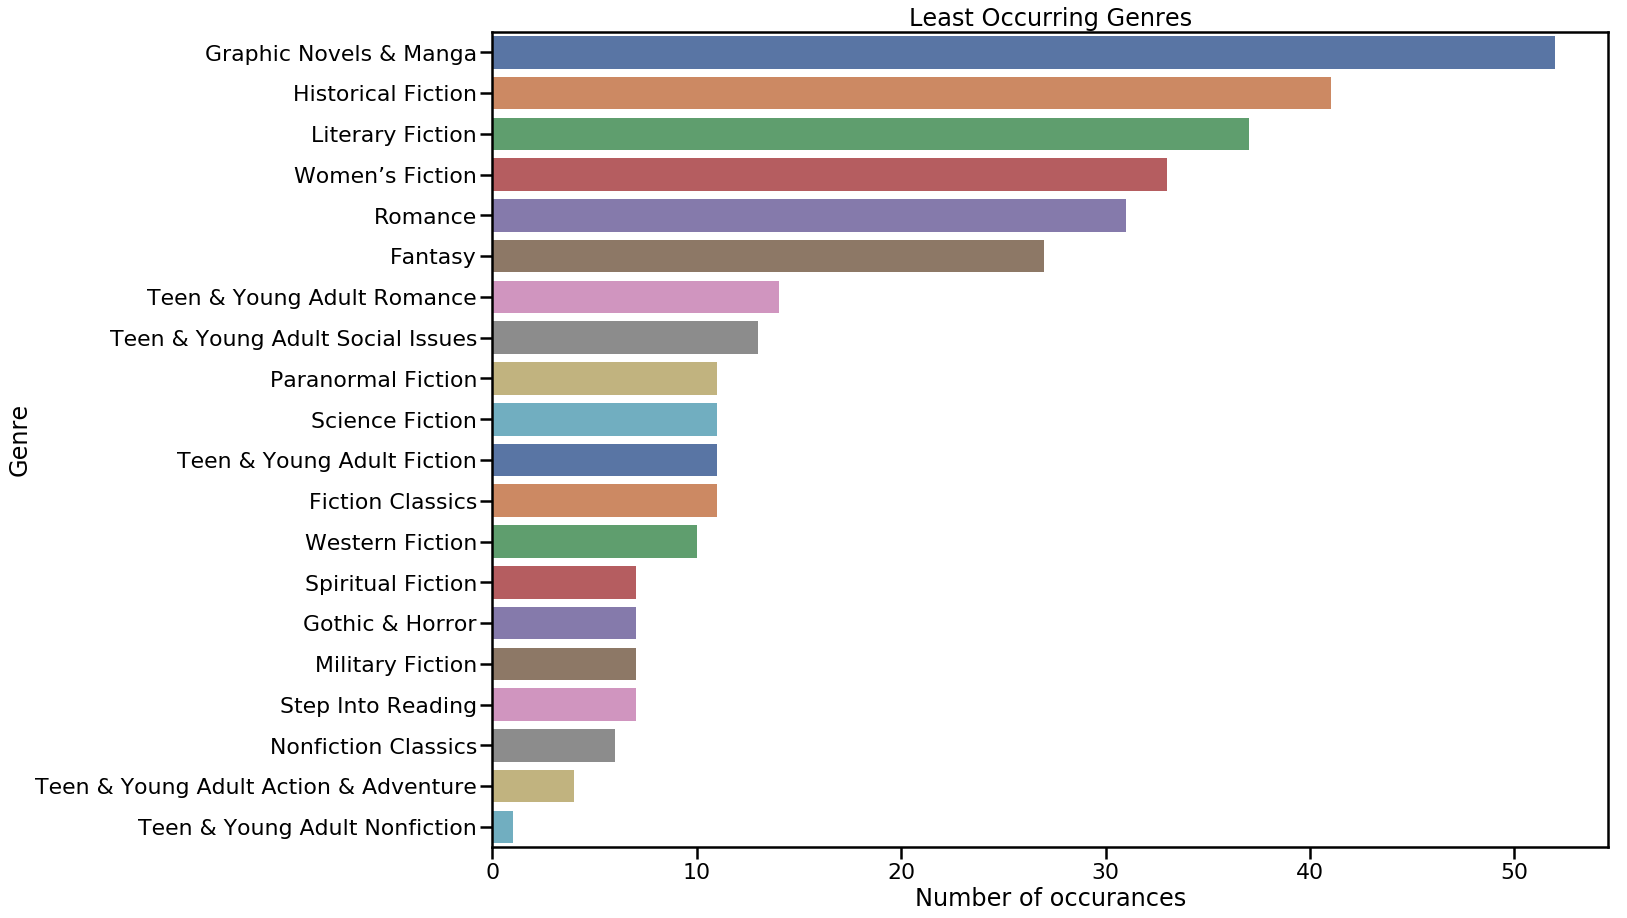

In [0]:
sns.set_context('poster')
plt.figure(figsize=(20,15))
last20categories = books_selected['Genre'].value_counts()[-20:]
sns.barplot(x = last20categories, y = last20categories.index, palette='deep')
plt.title("Least Occurring Genres")
plt.xlabel("Number of occurances")
plt.ylabel("Genre")
plt.show()

#### Unite small classes with larger Genre classes

In [0]:
# Bring together all subcategories of Teen & Young Adult:
books_selected['Genre'] = [books_selected['Genre'][i][:18] if books_selected['Genre'][i][:19] == "Teen & Young Adult " else books_selected['Genre'][i] for i in books_selected.index ]

# Bring together all subcategories of Fiction:
books_selected['Genre'] = [books_selected['Genre'][i][-7:] if books_selected['Genre'][i][-8:] == " Fiction" else books_selected['Genre'][i] for i in books_selected.index ]
books_selected['Genre'] = ["Fiction" if books_selected['Genre'][i] == "Fantasy" else books_selected['Genre'][i] for i in books_selected.index ]
books_selected['Genre'] = ["Fiction" if books_selected['Genre'][i] == "Fiction Classics" else books_selected['Genre'][i] for i in books_selected.index ]

# Bring together all subcategories of Teen & Young Adult Books:
books_selected['Genre'] = ["Teen & Young Adult" if books_selected['Genre'][i] == "Children’s Middle Grade Books" else books_selected['Genre'][i] for i in books_selected.index ]

# Bring together all subcategories of Children’s Books:
books_selected['Genre'] = ["Children’s Books" if books_selected['Genre'][i] == "Step Into Reading" else books_selected['Genre'][i] for i in books_selected.index ]

#### Delete books with categories with less than 100 books in it

In [0]:
def remove_categories(df, boundary):
  before = len(df)
  categories_to_drop = df['Genre'].value_counts()[df['Genre'].value_counts() < boundary]
  df = df.reset_index()
  todrop = []
  for book in range(before-1):
    if df.iloc[book]['Genre'] in categories_to_drop.index:
      todrop.append(book)
  
  #drop relevant rows:
  df = df.drop(todrop, axis=0) 
  
  after = len(df)
  print("{} books had genres with less than {} instances and were therefore removed. {} Books are left.".format(before-after,boundary, after))
  return df

books_selected = remove_categories(books_selected, 100)


253 books had genres with less than 100 instances and were therefore removed. 85339 Books are left.


Now there are 25 different genres of books
They are:


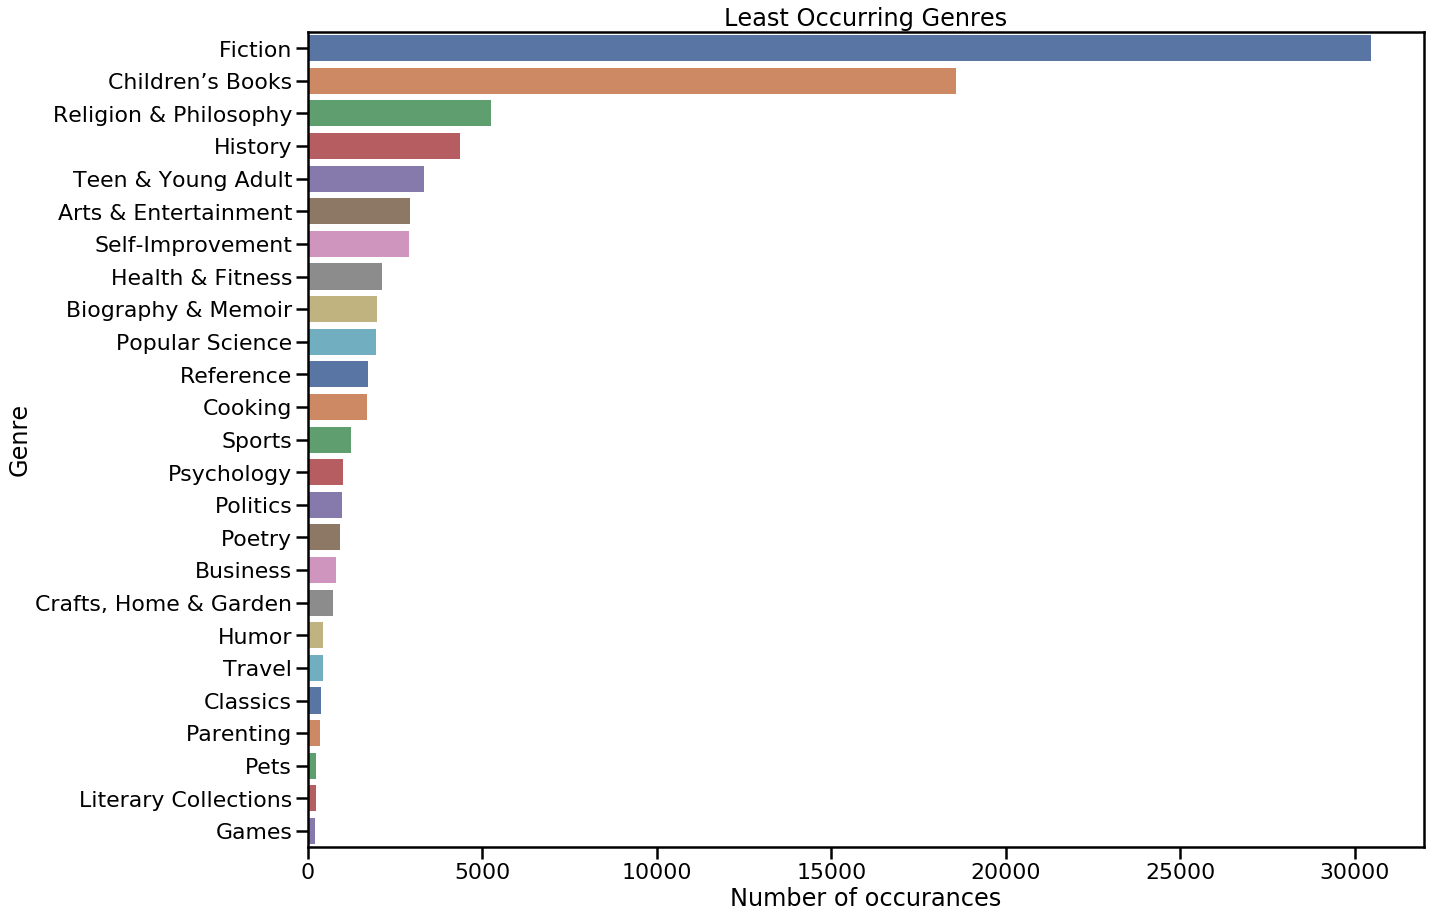

In [0]:
# Visualize new class distribution:
books_selected["Genre"] = [str(x) for x in books_selected["Genre"]]
print("Now there are {} different genres of books".format(len(np.unique(books_selected["Genre"]))))
print("They are:")

sns.set_context('poster')
plt.figure(figsize=(20,15))
allcategories = books_selected['Genre'].value_counts()
sns.barplot(x = allcategories, y = allcategories.index, palette='deep')
plt.title("Least Occurring Genres")
plt.xlabel("Number of occurances")
plt.ylabel("Genre")
plt.show()


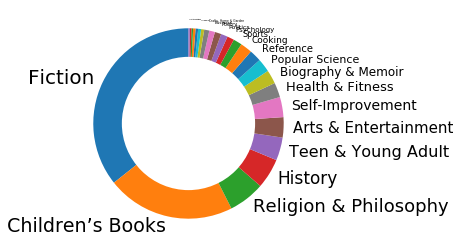

In [0]:
allcategories / len(books)*100

labels = allcategories.index
sizes = allcategories / len(books)*100
  
#pie chart:
fig1, ax1 = plt.subplots()
patches, texts   = ax1.pie(sizes, labels=labels ,startangle=90)
#ax1.axis('equal')
size = 20
for i in range(25):
  texts[i].set_fontsize(size)
  size -=1
fig1.x_ticks = False
    

#draw inner circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()



### Which are the authors with most books? 

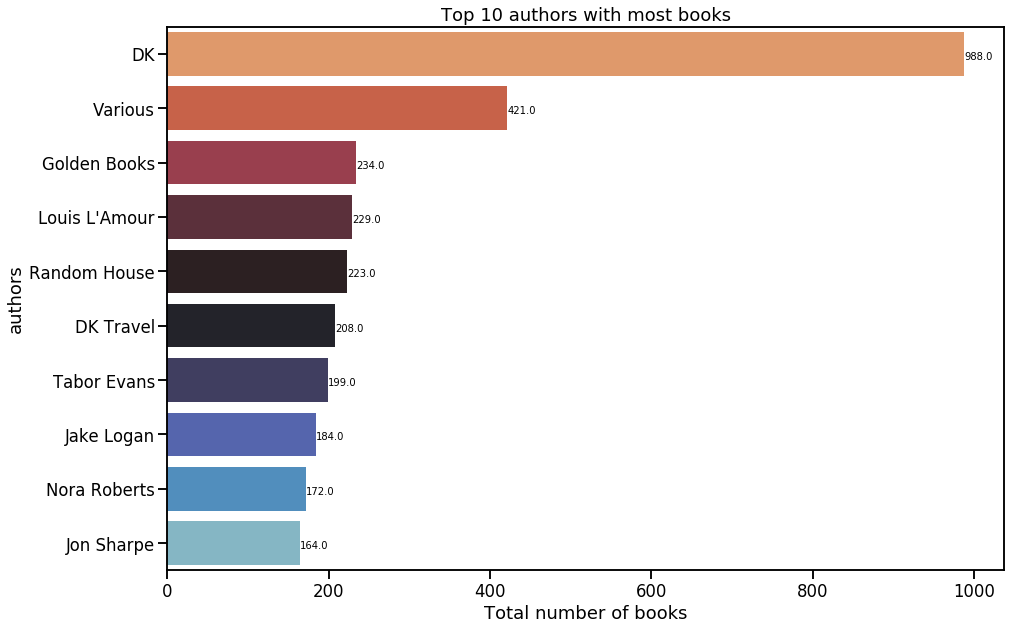

In [0]:
sns.set_context('talk')
most_books = books_selected.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(most_books['title'], most_books.index, palette='icefire_r')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')

We see some limitations of the data set: Often the publishing institution was identified as the author Dataset. This doesn't bother us for this project but indicates bad data quality.

### What is the distribution of books for all languages? 

In [0]:
# Detect language of the descriptions (first 150 characters should be sufficient to detect language):
lang = np.array([detect(desc[:150]) for desc in books_selected["description"]])

     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993460 sha256=c0f039587d165ec932cbafaaf22596dd48562ca824d55fa7163eb91be8a4ce72
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect


In [0]:
collections.Counter(lang)
# Count occurences of values:
x = collections.Counter(lang)
x

Counter({'de': 8, 'en': 85117, 'es': 210, 'fr': 1, 'id': 1, 'it': 1, 'so': 1})

Most of the descriptions are in english. Nevertheless we see 0.2% spanish books and a few german, 2 in indonesian and one in somali. Often, they include english book descriptions after the spanish/somali/german one, so we will split the descriptions and keep only the english part

#### Filter out english descriptions

In [0]:
# Get Indexes of non-english books:
non_english_indx = np.where(lang != "en")[0]
# Get descriptions of non-english books:
non_english_desc = books_selected.iloc[non_english_indx]["description"]

# If an english description exists split the text and keep only the english part:
for indx, i in enumerate(non_english_desc):
  if "english description" in i.lower():
    i = i.lower().split('english description')
    books_selected["description"][non_english_indx[indx]] = i[-1]

In [0]:
# Look again how many book descriptions are not in english now:
lang = np.array([detect(desc[:150]) for desc in books_selected["description"]])
collections.Counter(lang)
# Count occurences of values:
print(collections.Counter(lang))

Counter({'en': 85122, 'es': 207, 'de': 8, 'so': 1, 'fr': 1})


#### Delete resting non-english books

In [0]:
# Get Indexes of non-english books:
non_english_indx = np.where(lang != "en")[0]
len(non_english_indx)


217

In [0]:
before = len(books_selected)

books_selected = books_selected.drop(non_english_indx, axis =0)  

after = len(books_selected)

print("{} book descriptions were not in english and were therefore removed. {} Books are left.".format(before-after, after))

217 book descriptions were not in english and were therefore removed. 85122 Books are left.


### Which words occur most in the descriptions?

In [6]:
#tolower case + create unique word tokens
words = [desc.lower().split() for desc in books_selected["description"]] 

#remove all special characters, punctuation and spaces
words_neu = [re.sub('[^A-Za-z0-9]+', '',word) for word in chain.from_iterable(words)] 

#remove stopwords
words_neu = [word for word in words_neu if word not in stopwords] 

#only keep words with more than 3 characters
words_neu = [word for word in words_neu if len(word) > 3] 


text_word_frequency = Counter(words_neu)
text_word_frequency.most_common()[:15]

[('book', 37488),
 ('life', 32965),
 ('world', 27437),
 ('story', 20579),
 ('first', 20077),
 ('time', 19525),
 ('love', 19501),
 ('author', 17470),
 ('years', 15861),
 ('family', 14795),
 ('like', 14707),
 ('readers', 14536),
 ('york', 14372),
 ('even', 13908),
 ('find', 13811)]

In [0]:
# save locally:
books_selected.to_csv(project_folder + "/books_selected_clean.csv",index = None, header=True)

## 5 ) Split in Train, Test & Validation Set

The training data set must included all the possible ‘targets’ in it, otherwise the machine will not be trained for all the ‘targets’; and will generate huge errors when those datasets will appear in the test. We can use “stratify” in the ‘train_test_split’ which takes care of this.

In [0]:
# Import packages:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Set Google Drive Directory:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/data/'
project_folder = "/content/gdrive/My Drive/Genre Detection"

# import new version with scraped book descriptions directly 
books_selected = pd.read_csv(project_folder + "/books_selected_clean.csv", error_bad_lines=False)

Mounted at /content/gdrive


In [0]:
# split data into a temporary train set and a validation set:
X_train_temp, X_val, y_train_temp, y_val = train_test_split(
    books_selected["description"], books_selected["Genre"], test_size=0.2, random_state=1, stratify=books_selected["Genre"])


In [0]:
# split data in train and test set:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_temp, y_train_temp, test_size=0.25, random_state=1, stratify=y_train_temp)

## 5 ) Setting a Baseline

It is one important step is to define a baseline.This usually involves a simple rule or model trained on the training data and tested on the validation set, which is then used as a comparison with the final model. There are some common ways that to calculate a baseline result for a classification task:

*   Zero Rule Algorithm: select the class that has the most observations and use that class as the result for all predictions.
*   Using a simple model, which is then used as a comparison with the more advanced model




### Zero Rule

In [0]:
y_val.value_counts()[0]/len(y_val)

0.35508163142357974

The zero rule is to predict the class value that is most common in the training dataset, which is the "Fiction" class. For our train set that has 6.435 books of class “Fiction” and 17.981 books in total this means a baseline accuracy of 6.435/17.981 or 35,8%.

### Simple Classifier Baselines:

We will also test several simple models on our training data. Therefore, we chose chose to perform feature vectorization with a simple BOW based on word counts.

**Infos on Count Vectorizer:**

No stop_words have been removed and also no ngrams (ngram_range) have been taken into account. Therefore Accents are being removed ("Tom's" -> 'tom') and all words were set to lower case. Also no vocab was build, so all features were considered and stemming wasn't performed for calculating the baseline.

In [0]:
# Perform simple BOW Count Vectorization
vectorizer = CountVectorizer(lowercase = True, strip_accents='ascii')
#vectorizer.fit(books_selected["description"]) # Fit Count Vectorizer on all words that are in the corpus

X_train_vec = vectorizer.fit_transform(X_train_temp) # Fit and Transform the Count Vectorizer on all words that are in the training corpus
X_val_vec  = vectorizer.transform(X_val)  # Transform testing corpus

#### Random Forest Classifier

In [0]:
#RandomForest
rd = RandomForestClassifier()
rd.fit(X_train_vec, y_train_temp)
print('Train Accuracy-Score of Random Forest: {}'.format(rd.score(X_train_vec, y_train_temp)))
print('Test Accuracy-Score of Random Forest: {}'.format(rd.score(X_val_vec, y_val)))

Train Accuracy-Score of Random Forest: 0.9905563755761063
Test Accuracy-Score of Random Forest: 0.5801554310500633


The random forest already has a way better result than what we archieve with applying the zero rule.

#### Decision Tree Classifier

In [0]:
#Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_vec, y_train_temp)
print('Train Accuracy-Score of Decision Tree classifier: {}'.format(dt.score(X_train_vec, y_train_temp)))
print('Test Accuracy-Score of Decision Tree classifier: {}'.format(dt.score(X_val_vec, y_val)))

Train Accuracy-Score of Decision Tree classifier: 0.9998343223785282
Test Accuracy-Score of Decision Tree classifier: 0.5535273209229472


The decision tree performs slightly worse, but also with 54-57% accuracy.

#### Logistic Regression Classifier

In [0]:
#LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_vec, y_train_temp)
print('Train Accuracy-Score of Logistic Regression: {}'.format(logreg.score(X_train_vec, y_train_temp)))
print('Test  Accuracy-Score of Logistic Regression: {}'.format(logreg.score(X_val_vec, y_val)))

Train Accuracy-Score of Logistic Regression: 0.9994577823297286
Test  Accuracy-Score of Logistic Regression: 0.8066148563166455


A simple logistic regression has an accuracy of 80% on the test set. It beats the Zero Rule and Decision Tree classifiers by far.

## 6 ) MLP to predict Book Genre

Multilayer Perceptrons, or MLPs for short, are the classical type of neural network.

They are comprised of one or more layers of neurons. Data is fed to the input layer, there may be one or more hidden layers providing levels of abstraction, and predictions are made on the output layer, also called the visible layer.

#### Text Cleaning

Before feeding the classifier with the training data, the text data has to be cleaned. This includes converting the text to lower case, punctuation, white space and stop words. Stop words are extremely common words which appear to be of little value for the content. Then the message is converted to a sequence of unigram and bigram word tokens. In our case, Bigrams are sequences of two adjacent words from a sentence. They are very efficient and easy for containing meaning from text and therefore used in
various text categorization tasks.

In [0]:
#Define a cleaning function:
def clean(sentence):
  # set everything to lower space:
  words = sentence.lower()
  
  # remove special characters and punctuation:
  cleaned_words = re.sub('[^A-Za-z0-9]+', ' ',words).split()

  # remove stopwords:
  cleaned_words_nostop = [word for word in cleaned_words if word not in stopwords]
  
  # stem and only keep words with more than 3 characters
  #porter = PorterStemmer()
  #final_words = [porter.stem(word) for word in cleaned_words_nostop if len(word) > 3] 
  
   # only keep words with more than 3 characters
  final_words = [word for word in cleaned_words_nostop if len(word) > 3] 
  
  return final_words


In [10]:
#Test cleaning funtion:
r = random.randint(1,len(books_selected))
print(books_selected["title"][r])
clean(books_selected["description"][r])[:10]

Lucky Jim


['regarded',
 'many',
 'finest',
 'funniest',
 'comic',
 'novel',
 'twentieth',
 'century',
 'lucky',
 'remains']

#### Vectorization with TF-IDF

Then a Term Frequency–Inverse Document Frequency (TF-IDF)
matrix was built making the words machine-readable and serving as the input to the classifier.
It is calculated with the Term Frequency (TF), measuring how frequently a term occurs in a document,
and the Inverse Document Frequency (IDF), measuring how important a term is to a collection of
documents. The TF-IDF score considers only the weighted frequency of the terms and was calculated
using scikit lean’s TF-IDF Vectorizer function. This step is necessary to select the key terms for the
document set and give less relevant terms a smaller weight, as they are most likely to be noise sources
and of no use. Also, the classifier requires language to be transformed into some sort of numerical
representation in order to be processable. The TF-IDF matrix creates a statistical vector, counting the
weighted occurrences of words of each document in the document corpus, with which the classifier
can work.

TF = (Number of times term t appears in a document / Total number of terms in the document)

IDF = (Total number of documents / 1+ Number of documents with word t in it)

TF-IDF = TF x log(IDF) 

*1 in IDF is added to avoid division by 0. This smoothings is activated by default in sklearn's TfidfVectorizer*

In [0]:
def tfidf_features(X_train, X_test):
    tfidf = TfidfVectorizer(binary=False, analyzer = clean)
  
    # Transform the X_train to fit the TFIFD corpus
    X_train_vec = tfidf.fit_transform(X_train)
    X_train_vec = X_train_vec.astype('float32')
    
    # Transform the X_test to fit the TFIFD corpus
    X_test_vec = tfidf.transform(X_test)
    X_test_vec = X_test_vec.astype('float32')
  
    return X_train_vec, X_test_vec

def tf_features(X_train, X_test):
  # Perform simple BOW Count Vectorization
    vectorizer = CountVectorizer(analyzer = clean)
    #vectorizer.fit(books_selected["description"]) # Fit Count Vectorizer on all words that are in the corpus

    X_train_vec = vectorizer.fit_transform(X_train) # Fit and Transform the Count Vectorizer on all words that are in the training corpus
    X_train_vec = X_train_vec.astype('float32')
    
    X_test_vec  = vectorizer.transform(X_test)  # Transform testing corpus
    X_test_vec = X_test_vec.astype('float32')
  
    return X_train_vec, X_test_vec

In [0]:
X_train_vec, X_test_vec = tfidf_features(X_train, X_test)
#X_train_vec, X_test_vec = tf_features(X_train, X_test) # to test BOW approach

### Label Encoding

Keras expects one-hot-coded labels

In [0]:
# Encoding labels into Numbers from 0 to 24:
lb = LabelEncoder()
y_train_int = lb.fit_transform(y_train)
y_test_int = lb.transform(y_test)

# Then encode integer labels to binary ones:
y_train_enc = keras.utils.to_categorical(y_train_int)
y_test_enc = keras.utils.to_categorical(y_test_int)



### Define Build_Model Function

We now initialise our neural net with one hidden layer consisting by default of $50$ units with a relu activation function and and an softmax output layer consisting of $25$ units (as many as classes).
We compile the model using categorical cross-entropy as it's a multi-class classification. Keras detects the output_shape and automatically determines which accuracy to use when accuracy is specified. For multi-class classification, categorical_accuracy will be used internally.

The input layer contains input neurons that send information to the hidden layer. The hidden layer sends data to the output layer. Every neuron has weighted inputs (synapses), an activation function (defines the output given an input), and one output. 

In [0]:
def build_model(
    # Default values:
    optimizer_ = 'rmsprop', 
    neurons_ = 50):
  
  # Initialize model:
  model = Sequential()
  
  # Add Layer 1:
  model.add(Dense(neurons_, input_dim=X_train_vec.shape[1]))
  model.add(Activation("relu"))
  
   # Add Output Layer:
  model.add(Dense(y_train_enc.shape[1]))
  model.add(Activation("softmax"))
  
  # Compile:
  model.compile(optimizer=optimizer_,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

  return model

Neural networks are notoriously difficult to configure and there are a lot of parameters that need to be set. On top of that, individual models can be very slow to train.

By wrapping the keras model with the KerasClassifier class, we can pass new arguments to our model. Then we can perform a grid search, where we pass hyperparameters to try.


### Grid Search best Parameters

**batches:**
Because we have 70% of 80000 training samples (books), we need to split them up to small groups (batches) and pass these batches of samples to our feedforward neural network subsesquently.

**neurons:**
That's the tricky part.  We need to determining our hidden layer size, that is the size of our first linear layer prior to the non-linear layer. A larger number implies a more complex model with more parameters which requires more training samples to learn and converge to a good model (also called curse of dimensionality). Hence, it is wise to pick the model size for the problem at hand. Because we assume it's a simple problem of recognizing book Genres, we typically would not need a big model to achieve state-of-the-art results.

On the flipside, too small of a hidden size would mean there would be insufficient model capacity to predict competently. In layman terms, too small of a capacity implies a smaller brain capacity so no matter how many training samples you give it, it has a maximum capacity in terms of its predictive power.

**epoch:**
An epoch means that you have successfully passed the whole training set, to the model. 


**optimizer:**
There are different optimization algorithm. They are all based on Gradient Descent, calculating the parameters' gradients multiplied by the learning rate then using it to update the parameters gradually. It's an iterative process where we want to minimize the loss function.


In [0]:
# create model
classifier = KerasClassifier(build_fn=build_model)

# define the grid search parameters
parameters = {'batch_size': [25, 32],
          'neurons_': [10, 30, 50, 100],
          'epochs': [5, 10, 15],
          'optimizer_': ['adam', 'rmsprop']}

# Grid search parameters:
grid = GridSearchCV(estimator=classifier, 
                    param_grid=parameters, 
                    scoring = 'accuracy',
                    cv = 3)

# Perform Grid Search - for computation reasons only 50% of the train set were actually used.
grid_result = grid.fit(X_train_vec, y_train_int, validation_data=(X_test_vec, y_test_enc))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


**Best Parameters:**

batch_size: 32, 

neurons: 50

epochs: 10

optimizer: 'rmsprop'

In [0]:
model = build_model()
history = model.fit(X_train_vec, y_train_enc, validation_data=(X_test_vec, y_test_enc), epochs=10, batch_size=32)

Train on 49795 samples, validate on 16599 samples
Epoch 1/10
49795/49795 [==============================] - 87s 2ms/step - loss: 1.3981 - acc: 0.6340 - val_loss: 0.8988 - val_acc: 0.7476
Epoch 2/10
49795/49795 [==============================] - 87s 2ms/step - loss: 0.7009 - acc: 0.8034 - val_loss: 0.7012 - val_acc: 0.7935
Epoch 3/10
49795/49795 [==============================] - 88s 2ms/step - loss: 0.5123 - acc: 0.8517 - val_loss: 0.6530 - val_acc: 0.8043
Epoch 4/10
49795/49795 [==============================] - 88s 2ms/step - loss: 0.4031 - acc: 0.8813 - val_loss: 0.6388 - val_acc: 0.8121
Epoch 5/10
49795/49795 [==============================] - 89s 2ms/step - loss: 0.3249 - acc: 0.9052 - val_loss: 0.6447 - val_acc: 0.8150
Epoch 6/10
49795/49795 [==============================] - 88s 2ms/step - loss: 0.2643 - acc: 0.9232 - val_loss: 0.6568 - val_acc: 0.8136
Epoch 7/10
49795/49795 [==============================] - 89s 2ms/step - loss: 0.2177 - acc: 0.9368 - val_loss: 0.6795 - val_acc

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


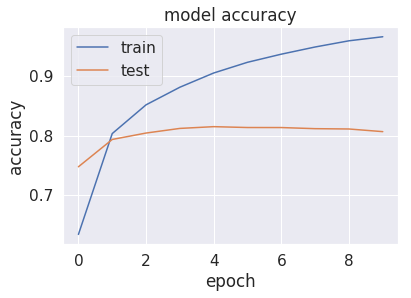

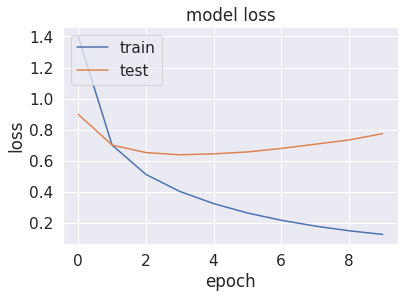

In [0]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**There's a lot more parameters that we did not test such as:**

**learning rate:**
Learning rate is probably the most important aspect of gradient descent and also other optimizers as well. It defines the step size. If you choose a large value as learning rate, you would be making drastic changes to the weights and bias values, i.e you would be taking huge jumps to reach the minimum of the loss function. If you choose a small value as learning rate, you lose the risk of overshooting the minima but your algorithm will longer time to converge.

**momentum:**
Almost always, gradient descent with momentum converges faster than the standard gradient descent algorithm. In the standard gradient descent algorithm, you would be taking larger steps in one direction and smaller steps in another direction which slows down the algorithm. Momentum avoids this. It restricts the oscillation in one direction so that the algorithm can converge faster. 

### Build final model

Train all training data (Train and test set) and validate is on the validation set

In [0]:
# Build TF-IDF with all training data (tran and test) and test on validation data set:
X_train_vec, X_val_vec = tfidf_features(X_train_temp, X_val)


#encode labels:
# Then encode integer labels to binary ones:
y_train_int = lb.fit_transform(y_train_temp)
y_val_int = lb.transform(y_val)

# Then encode integer labels to binary ones:
y_train_enc = keras.utils.to_categorical(y_train_int)
y_val_enc = keras.utils.to_categorical(y_val_int)

In [15]:
model = build_model()
model.summary() # summary of the model.






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                6495250   
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
activation_2 (Activation)    (None, 25)                0         
Total params: 6,496,525
Trainable params: 6,496,525
Non-trainable params: 0
_________________________________________________________________


In [16]:
# with validation data included:
history = model.fit(X_train_vec, y_train_enc, validation_data=(X_val_vec, y_val_enc), epochs=10, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 66394 samples, validate on 16599 samples
Epoch 1/10
66394/66394 [==============================] - 44s 664us/step - loss: 1.2666 - acc: 0.6639 - val_loss: 0.7953 - val_acc: 0.7771
Epoch 2/10
66394/66394 [==============================] - 37s 558us/step - loss: 0.6345 - acc: 0.8185 - val_loss: 0.6534 - val_acc: 0.8090
Epoch 3/10
66394/66394 [==============================] - 37s 552us/step - loss: 0.4787 - acc: 0.8593 - val_loss: 0.6214 - val_acc: 0.8164
Epoch 4/10
66394/66394 [==============================] - 36s 535us/step - loss: 0.3883 - acc: 0.8852 - val_loss: 0.6195 - val_acc: 0.8210
Epoch 5/10
66394/66394 [==============================] - 35s 534us/step - loss: 0.3211 - acc: 0.9056 - val_loss: 0.6335 - val_acc: 0.8208
Epoch 6/10
66394/66394 [==============================] - 35s 531us/step - loss: 0.2699 - acc: 0.9211 - val_loss: 0.6486 - val_acc: 0.8202
Epoch 7/10
66394/6639

In [17]:
# Print results.
print('Validation accuracy: {acc}, loss: {loss}'.format(
    acc=history.history['val_acc'][-1], loss=history.history['val_loss'][-1]))


Validation accuracy: 0.8133622507667231, loss: 0.7565138560223632


## 7 ) Evaluation

We have broadly three types of metrics to evaluate multiclass classification:

*   Micro-average will aggregate the contributions of all classes to compute the average metric.

*   Macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally)

*   Weighted average is computed by taking the average, over all the classes, of the fraction of correct predictions in this class (i.e. the number of correctly predicted instances in that class, divided by the total number of instances in that class).


Most commonly used metrics for multi-classes are F1 score and Average Accuracy. There is yet no well-developed ROC-AUC score for multi-class.


### Classification Report

In [0]:
#predict validation set with class probabilities:
predictions_encoded = model.predict_proba(X_val_vec)

In [19]:
predictions = lb.inverse_transform([np.argmax(pred) for pred in predictions_encoded])
predictions

array(['Children’s Books', 'Children’s Books', 'Biography  Memoir', ...,
       'Fiction', 'Cooking', 'Biography  Memoir'], dtype=object)

In [20]:
list(zip(predictions, y_val))[-15:]

[('Poetry', 'Poetry'),
 ('Children’s Books', 'Children’s Books'),
 ('Parenting', 'Parenting'),
 ('History', 'Children’s Books'),
 ('Fiction', 'Fiction'),
 ('Poetry', 'Poetry'),
 ('Fiction', 'Fiction'),
 ('Crafts, Home  Garden', 'Crafts, Home  Garden'),
 ('Children’s Books', 'Children’s Books'),
 ('Children’s Books', 'Children’s Books'),
 ('Children’s Books', 'Children’s Books'),
 ('Religion  Philosophy', 'Religion  Philosophy'),
 ('Fiction', 'Fiction'),
 ('Cooking', 'Cooking'),
 ('Biography  Memoir', 'Biography  Memoir')]

In [21]:
print(classification_report(y_val, predictions))

                       precision    recall  f1-score   support

  Arts  Entertainment       0.76      0.77      0.77       418
    Biography  Memoir       0.59      0.64      0.61       934
             Business       0.70      0.63      0.66       134
     Children’s Books       0.90      0.91      0.90      3656
             Classics       0.49      0.45      0.47       135
              Cooking       0.91      0.90      0.90       563
 Crafts, Home  Garden       0.84      0.83      0.84       255
              Fiction       0.90      0.94      0.92      5894
                Games       0.92      0.62      0.74        53
Graphic Novels  Manga       0.68      0.30      0.42        43
      Health  Fitness       0.71      0.71      0.71       339
              History       0.47      0.39      0.42       306
                Humor       0.66      0.49      0.57       281
 Literary Collections       0.50      0.13      0.21        23
            Parenting       0.78      0.70      0.74  

### Confusion Matrix

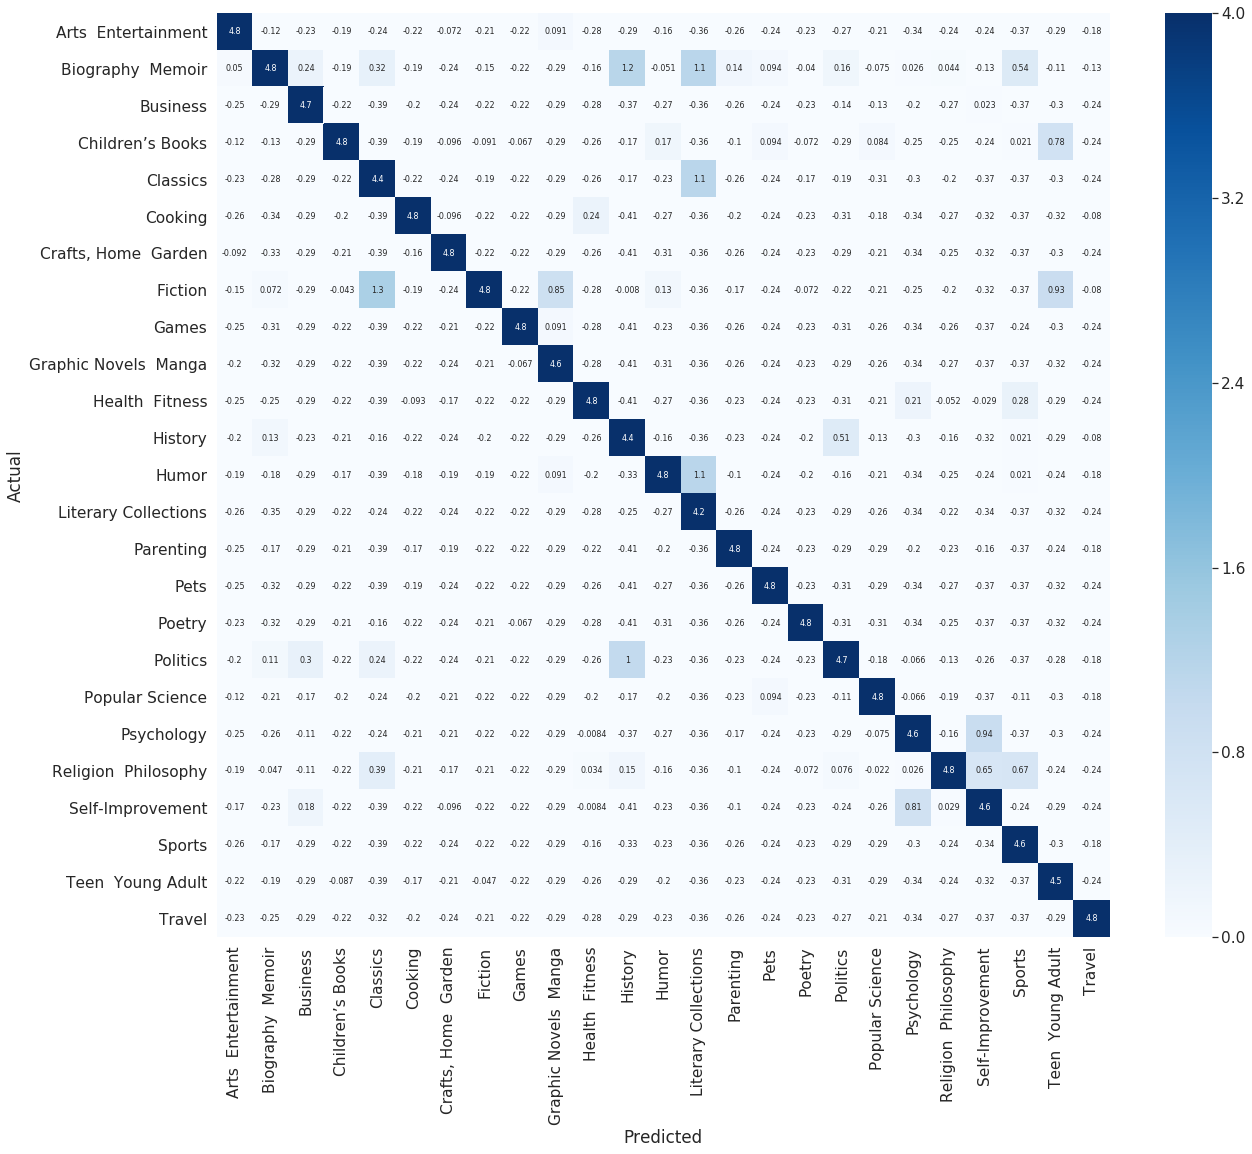

In [22]:
data = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,17))
sns.set(font_scale=1.4)#for label size
df_norm_col=(df_cm*100  / df_cm.sum(axis = 1)) #normalize
sns.heatmap(df_norm_col, cmap="Blues", annot=True,annot_kws={"size": 12}, vmin=0, vmax=100) # font size

### Precision Recall Curve

In [0]:
# Encoding labels into Numbers from 0 to 24:
#lb = LabelEncoder()
y_val_int = lb.transform(y_val)

# Then encode integer labels to binary ones:
y_val_enc = keras.utils.to_categorical(y_val_int)

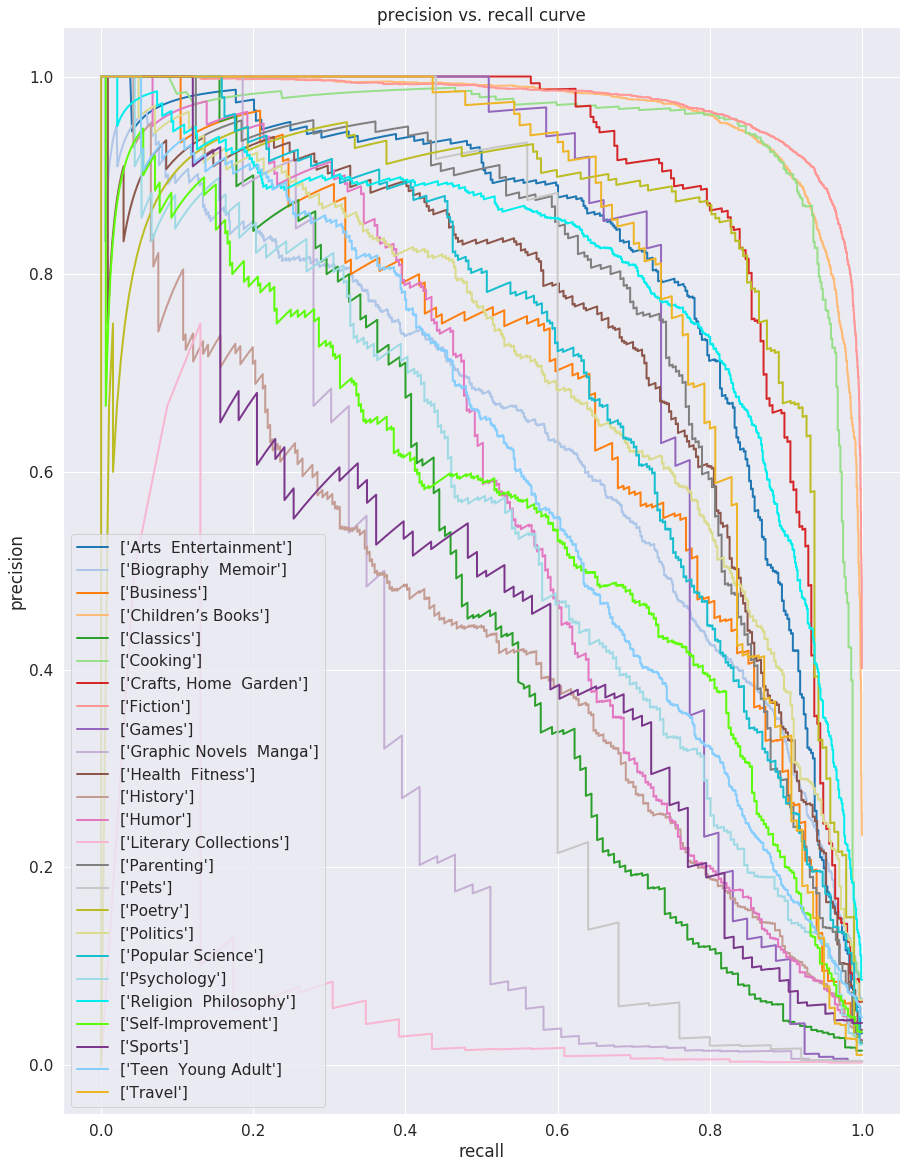

In [24]:
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve

# precision recall curve
precision = dict()
recall = dict()
plt.figure(figsize=(15,20)) 

#colors:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
                  '#00EEEE', '#5DFC0A', '#7A378B', '#87CEFF', '#EEB426']

for i in range(25):
    precision[i], recall[i], _ = precision_recall_curve(y_val_enc[:, i],
                                                        predictions_encoded[:, i])   
    plt.plot(recall[i], precision[i], lw=2, color=color_sequence[i], label= lb.inverse_transform([i]))




plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

### ROC- Curve per class

ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-class or multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

In [0]:
from sklearn.metrics import roc_curve, auc
from scipy import interp


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(25):
    fpr[i], tpr[i], _ = roc_curve(y_val_enc[:, i],predictions_encoded[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_enc[:, i],predictions_encoded[:, i])  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(25)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(25):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 25

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


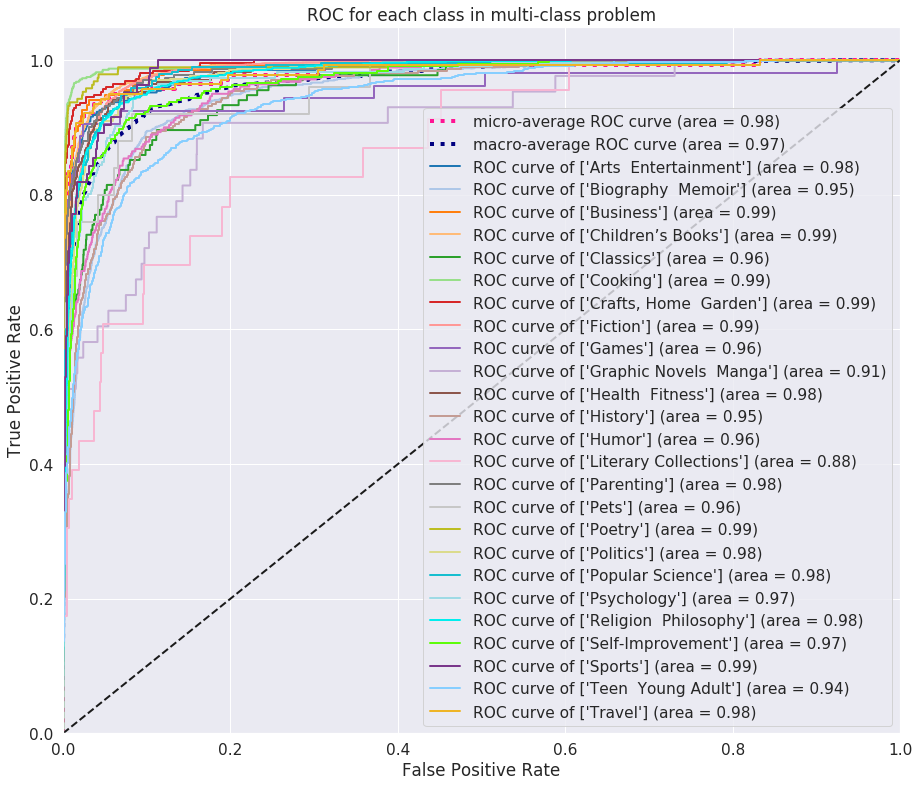

In [30]:
# Plot all ROC curves
lw = 2
plt.figure(figsize=(15,13)) 
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


for i in range(25):
    plt.plot(fpr[i], tpr[i], color=color_sequence[i], lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(lb.inverse_transform([i]), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for each class in multi-class problem')
plt.legend(loc="lower right")
plt.show()

**True positive rate** (or sensitivity): 

TPR=TP/(TP+FN)

**False positive rate:** 

FPR=FP/(FP+TN)